# ECG Heartbeat Categorization
In this notebook, we aim to build a model that can classify ECG signals into normal or anomalous categories. We will use datasets from the MIT-BIH Arrhythmia Database and the PTB Diagnostic ECG Database.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Reshape
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import StratifiedKFold
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.layers import LSTM, Dense, Dropout
from keras import backend as K
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Loading
We are using four datasets: two from the MIT-BIH Arrhythmia Database (`mitbih_train.csv`, `mitbih_test.csv`) and two from the PTB Diagnostic ECG Database (`ptbdb_normal.csv`, `ptbdb_abnormal.csv`). Below, we load the datasets into Pandas DataFrames for further analysis and processing.


In [5]:
#loading datasets

mitbih_train_path = r'/content/drive/MyDrive/Dataset/mitbih_train.csv'
mitbih_test_path = r'/content/drive/MyDrive/Dataset/mitbih_test.csv'
ptbdb_normal_path = r'/content/drive/MyDrive/Dataset/ptbdb_normal.csv'
ptbdb_abnormal_path = r'/content/drive/MyDrive/Dataset/ptbdb_abnormal.csv'

mitbih_train = pd.read_csv(mitbih_train_path, header=None)
mitbih_test = pd.read_csv(mitbih_test_path, header=None)
ptbdb_normal = pd.read_csv(ptbdb_normal_path, header=None)
ptbdb_abnormal = pd.read_csv(ptbdb_abnormal_path, header=None)

## Exploratory Data Analysis (EDA)
We'll start by exploring the basic structure of the datasets and their class distributions.


In [6]:
# Function to print basic dataset info
def print_info(dataset, name):
    print(f"{name} Dataset:")
    print(f"Rows: {dataset.shape[0]}")
    print(f"Columns: {dataset.shape[1]}")
    print(f"Class distribution: {dataset.iloc[:, -1].value_counts()}\n")

# Display basic information about each dataset
print_info(mitbih_train, 'MITBIH Train')
print_info(mitbih_test, 'MITBIH Test')
print_info(ptbdb_normal, 'PTBDB Normal')
print_info(ptbdb_abnormal, 'PTBDB Abnormal')

labels = ['Normal beat', 'Supraventricular premature beat',
          'Premature ventricular contraction', 'Fusion of ventricular and normal beat',
          'Unclassifiable beat']

MITBIH Train Dataset:
Rows: 87554
Columns: 188
Class distribution: 0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64

MITBIH Test Dataset:
Rows: 21892
Columns: 188
Class distribution: 0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: 187, dtype: int64

PTBDB Normal Dataset:
Rows: 4046
Columns: 188
Class distribution: 0.0    4046
Name: 187, dtype: int64

PTBDB Abnormal Dataset:
Rows: 10506
Columns: 188
Class distribution: 1.0    10506
Name: 187, dtype: int64



### Data Visualization
Visualizations help understand the distribution of different classes in the datasets and to inspect the ECG signal patterns.


In [7]:
# Calculate the balance of classes
class_counts = mitbih_train.iloc[:, -1].value_counts().sort_index()
class_percentage = class_counts / len(mitbih_train) * 100

# Map class indices to labels
class_counts.index = [labels[int(i)] for i in class_counts.index]
class_percentage.index = [labels[int(i)] for i in class_percentage.index]

# Print class counts and percentages
print("Class Counts:")
print(class_counts)
print("\nClass Percentage:")
print(class_percentage)

Class Counts:
Normal beat                              72471
Supraventricular premature beat           2223
Premature ventricular contraction         5788
Fusion of ventricular and normal beat      641
Unclassifiable beat                       6431
Name: 187, dtype: int64

Class Percentage:
Normal beat                              82.772917
Supraventricular premature beat           2.539005
Premature ventricular contraction         6.610777
Fusion of ventricular and normal beat     0.732120
Unclassifiable beat                       7.345181
Name: 187, dtype: float64


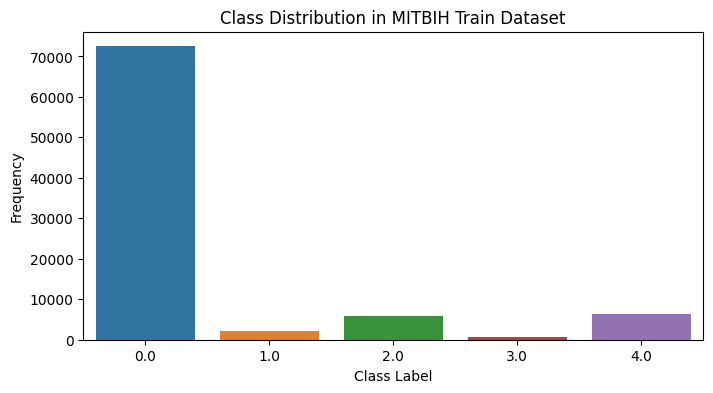

In [8]:
# Function to plot class distribution
def plot_class_distribution(dataset, title):
    plt.figure(figsize=(8, 4))
    sns.countplot(x=dataset.iloc[:, -1])
    plt.title(title)
    plt.xlabel('Class Label')
    plt.ylabel('Frequency')
    plt.show()

# Plot class distribution for each dataset
plot_class_distribution(mitbih_train, 'Class Distribution in MITBIH Train Dataset')

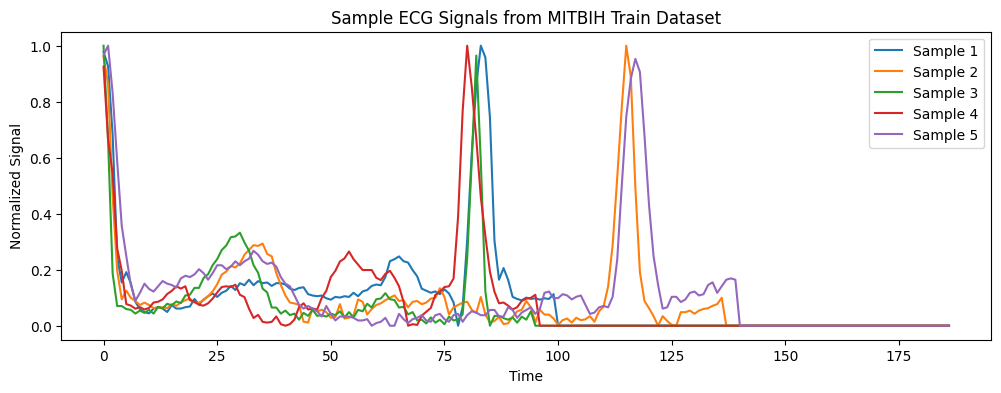

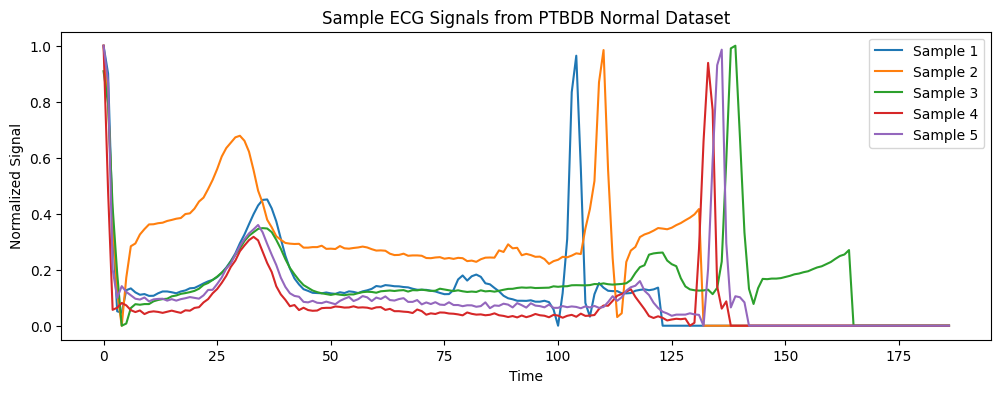

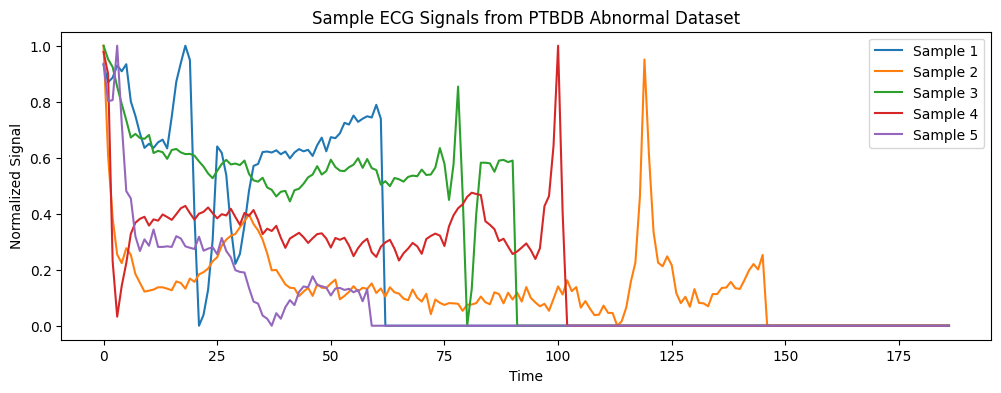

In [9]:
# Plot sample ECG signals from each dataset

def plot_samples(dataset, title):
    plt.figure(figsize=(12, 4))
    for i in range(5):
        plt.plot(dataset.iloc[i, :-1], label=f'Sample {i+1}')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized Signal')
    plt.legend()
    plt.show()

# Plot ECG signals
plot_samples(mitbih_train, 'Sample ECG Signals from MITBIH Train Dataset')
plot_samples(ptbdb_normal, 'Sample ECG Signals from PTBDB Normal Dataset')
plot_samples(ptbdb_abnormal, 'Sample ECG Signals from PTBDB Abnormal Dataset')

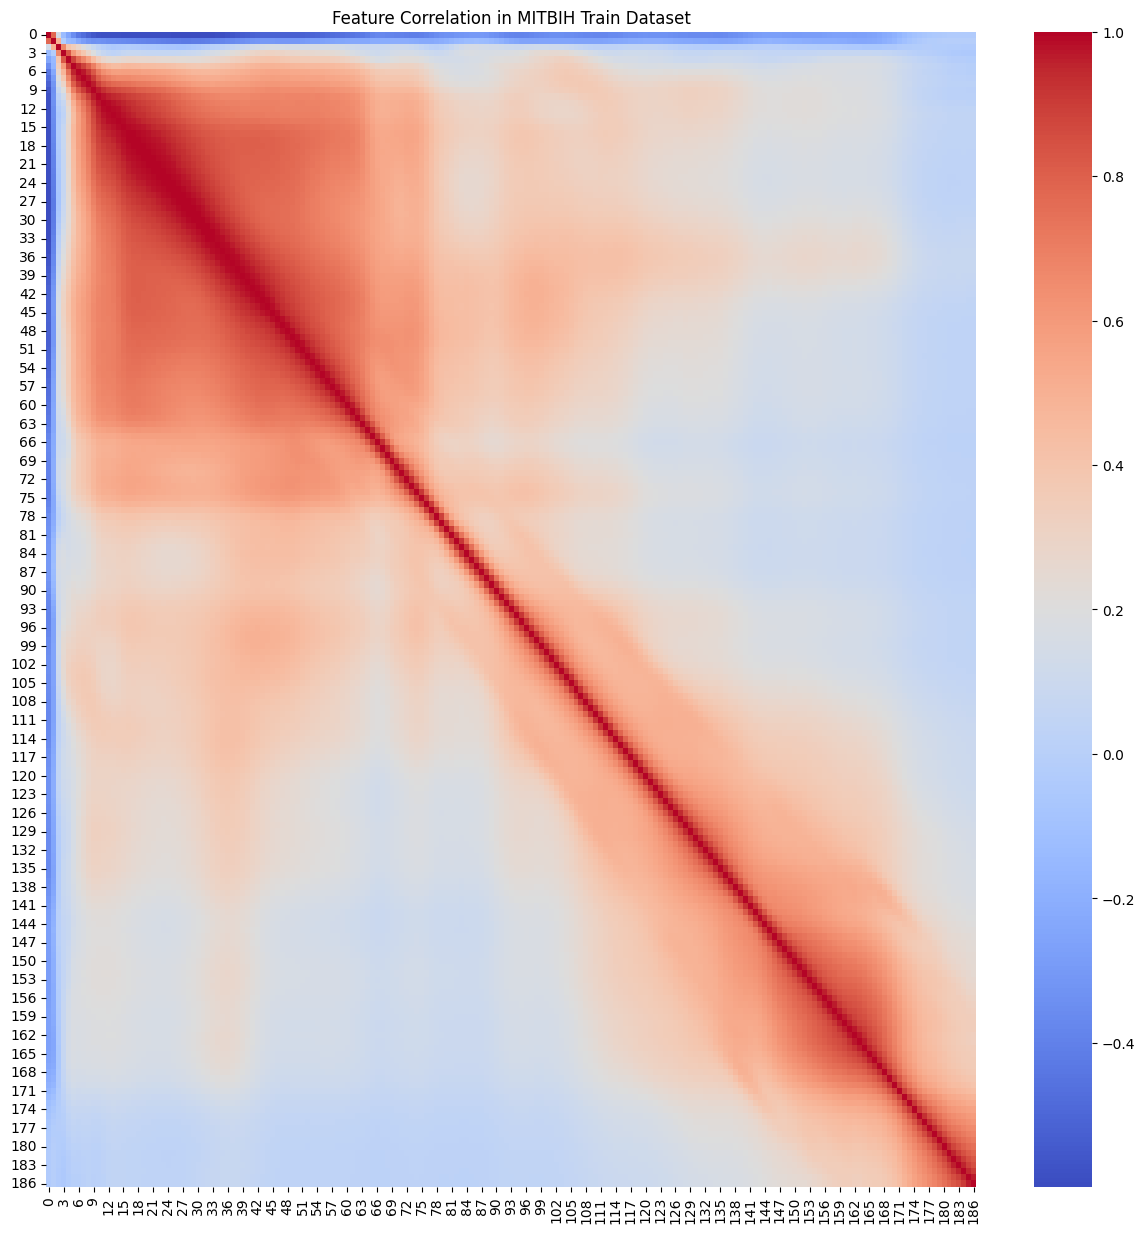

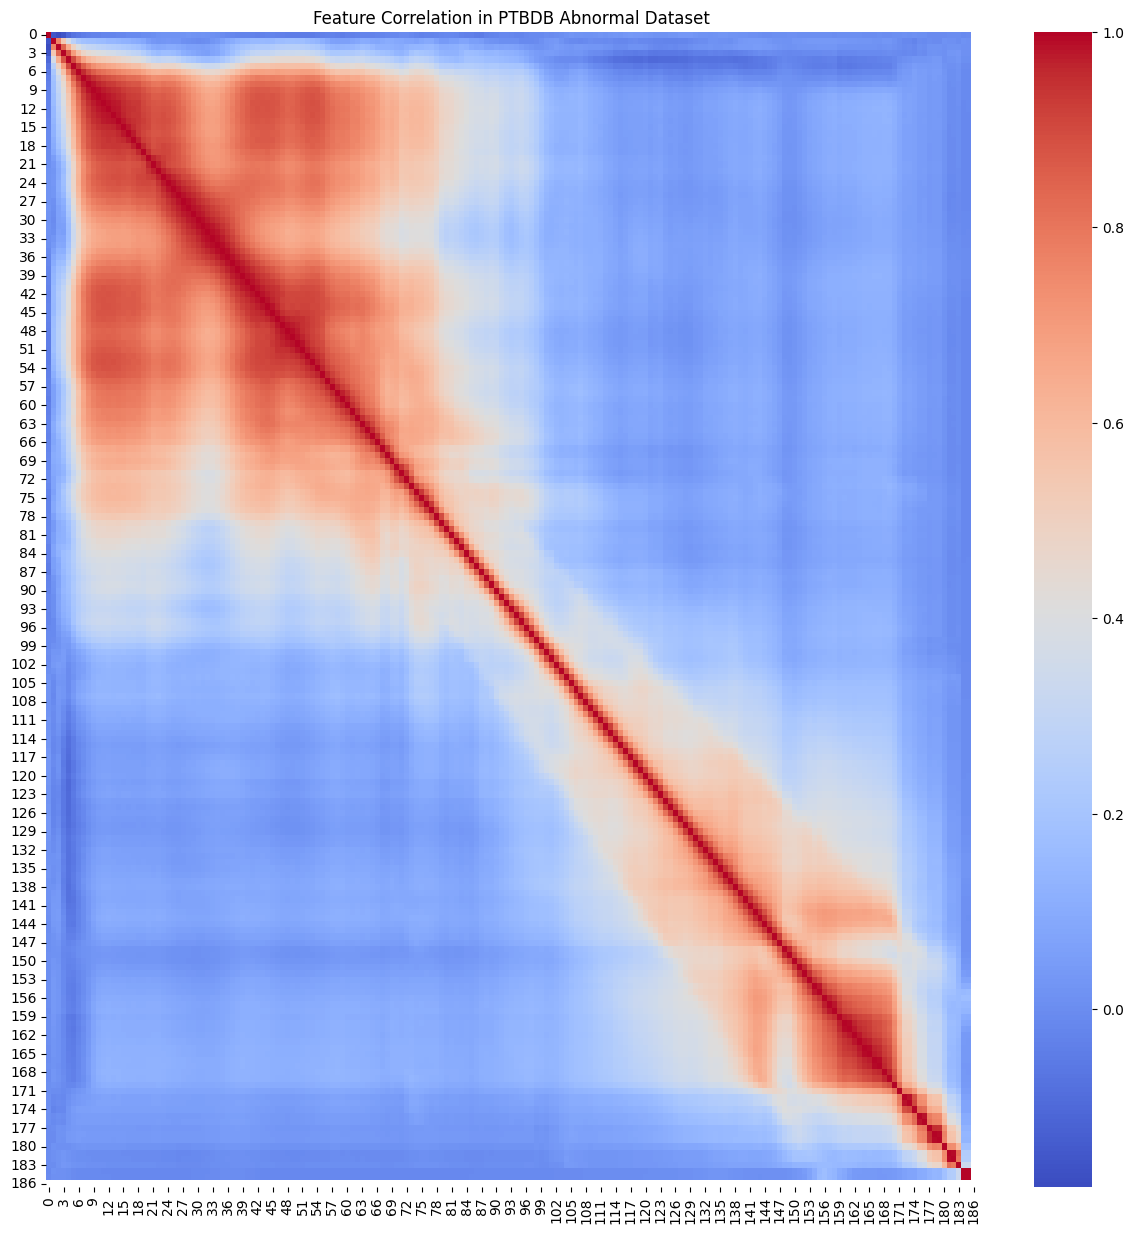

In [10]:
def plot_correlation(dataset, title):
    plt.figure(figsize=(15, 15))
    sns.heatmap(dataset.iloc[:, :-1].corr(), annot=False, cmap='coolwarm')
    plt.title(title)
    plt.show()

# Plot correlation heatmaps
plot_correlation(mitbih_train, 'Feature Correlation in MITBIH Train Dataset')
plot_correlation(ptbdb_abnormal, 'Feature Correlation in PTBDB Abnormal Dataset')

## Data Preprocessing
Proper data preprocessing is crucial for the performance of our model. This includes relabeling, combining datasets, and applying Synthetic Minority Over-sampling Technique (SMOTE) to address class imbalance.


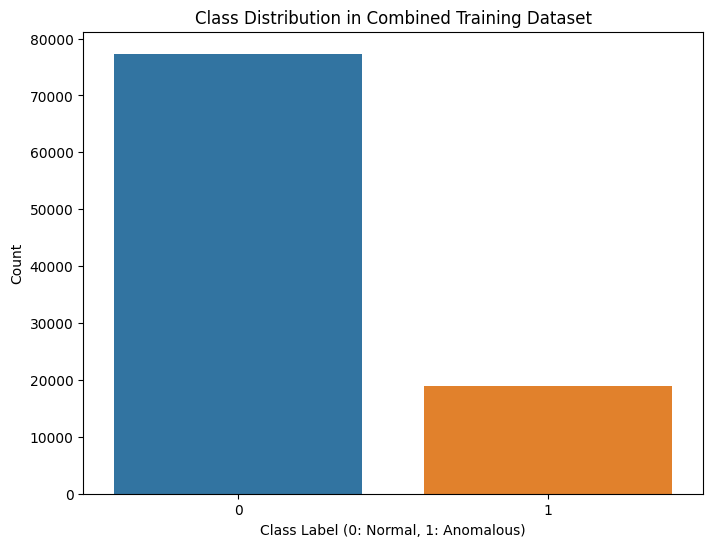

In [11]:
# Relabel the MITBIH Train dataset
mitbih_train['label'] = mitbih_train[187].apply(lambda x: 0 if x == 0 else 1)  # '0' for normal, '1' for anomalous

# Relabel the MITBIH Test dataset
mitbih_test['label'] = mitbih_test[187].apply(lambda x: 0 if x == 0 else 1)  # '0' for normal, '1' for anomalous

# Combine ptbdb_normal and ptbdb_abnormal, then split
ptbdb_combined = pd.concat([ptbdb_normal.drop(187, axis=1), ptbdb_abnormal.drop(187, axis=1)])
ptbdb_combined['label'] = ptbdb_combined.apply(lambda row: 0 if row.name in ptbdb_normal.index else 1, axis=1)
ptbdb_train, ptbdb_test = train_test_split(ptbdb_combined, test_size=0.4, random_state=42)

# Combine datasets for training
combined_train = pd.concat([mitbih_train.drop(187, axis=1), ptbdb_train])

# Combine datasets for testing
combined_test = pd.concat([mitbih_test.drop(187, axis=1), ptbdb_test])

# Shuffle the combined datasets
combined_train = combined_train.sample(frac=1, random_state=42).reset_index(drop=True)
combined_test = combined_test.sample(frac=1, random_state=42).reset_index(drop=True)

# Visualize the class distribution in the combined training dataset
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=combined_train)
plt.title('Class Distribution in Combined Training Dataset')
plt.xlabel('Class Label (0: Normal, 1: Anomalous)')
plt.ylabel('Count')
plt.show()


<ipython-input-12-9a12ce195888>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  resampled_data['label'] = y_resampled


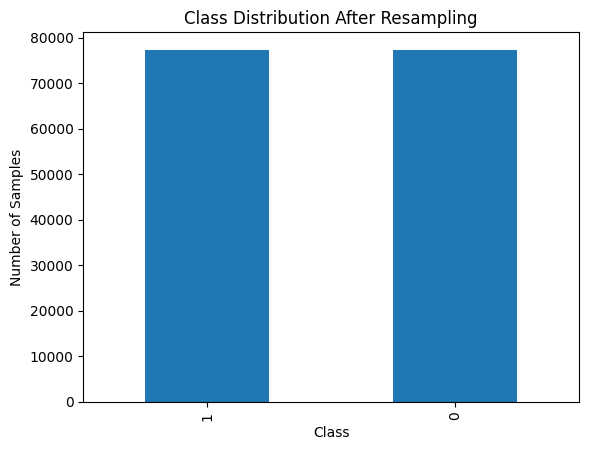

In [12]:
# Split the dataset into features and labels
# Assuming the 'label' column is your binary classification target
X = combined_train.drop('label', axis=1)
y = combined_train['label']

# Since we saw that there are no NaN values in other columns, we can proceed with SMOTE directly
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Combine the resampled features and labels back into a DataFrame
resampled_data = pd.DataFrame(X_resampled, columns=X.columns)
resampled_data['label'] = y_resampled

# Check the new class distribution
resampled_class_distribution = resampled_data['label'].value_counts()

# Plotting the class distribution after resampling
resampled_class_distribution.plot(kind='bar', title='Class Distribution After Resampling')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

In [13]:
X = resampled_data.drop('label', axis=1)
y = resampled_data['label']

# Split the dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    X, y.values,
    random_state=42,
    stratify=y.values,
    shuffle=True,
    train_size=0.75
)

# Print the shape of the training and validation data
print("The shape of training data : ", x_train.shape, y_train.shape)
print("The shape of validation data : ", x_val.shape, y_val.shape)

The shape of training data :  (116004, 187) (116004,)
The shape of validation data :  (38668, 187) (38668,)


## Model Building
We will experiment with different deep learning architectures including CNN and LSTM to find the best performing model for our binary classification task.


## Model 1: Convolutional Neural Network (CNN) for ECG Signal Classification

In our first model, we implemented a Convolutional Neural Network (CNN) to classify ECG signals into normal and anomalous categories. This approach leverages the spatial feature extraction capabilities of CNNs, which are particularly effective for time-series data like ECG signals. To enhance model robustness and address class imbalance, we introduced Gaussian noise to our data and applied the SMOTE technique, respectively. The model architecture includes convolutional layers paired with batch normalization and dropout layers to prevent overfitting. We trained the model using class weights to handle imbalanced data, employing early stopping and model checkpointing to ensure we capture the best version of the model without overfitting.

In [14]:
#Try 1 With CNN MODEL

# Function to add Gaussian noise
def add_gaussian_noise(X, mean=0, std=0.01):
    noise = np.random.normal(mean, std, X.shape)
    X_noisy = X + noise
    return X_noisy

# Assuming combined_train and combined_test are already defined and preprocessed dataframes

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(combined_train.drop('label', axis=1), combined_train['label'])

# Split the dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    X_resampled, y_resampled,
    random_state=42,
    stratify=y_resampled,
    shuffle=True,
    train_size=0.75
)

# Add noise to training data
x_train_noisy = add_gaussian_noise(x_train)

# Initialize the scaler
scaler = StandardScaler()
scaler.fit(x_train_noisy)

# Apply scaling to the training, validation, and test set
X_train_scaled = scaler.transform(x_train_noisy).reshape(-1, x_train_noisy.shape[1], 1)
X_val_scaled = scaler.transform(x_val).reshape(-1, x_val.shape[1], 1)
X_test_scaled = scaler.transform(combined_test.drop('label', axis=1)).reshape(-1, combined_test.drop('label', axis=1).shape[1], 1)

# Define the LSTM model
def build_cnn(input_shape):
    model = Sequential()

    # First Convolutional Layer
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=3, strides=2, padding="same"))
    model.add(Dropout(0.5))

    # Second Convolutional Layer
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2, strides=2, padding="same"))
    model.add(Dropout(0.5))

    # Third Convolutional Layer
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2, strides=2, padding="same"))
    model.add(Dropout(0.5))

    # Flatten and Dense Layers
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

input_shape = (X_train_scaled.shape[1], 1)

# Build and compile the LSTM model
model = build_cnn(input_shape)

# Define the callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, verbose=1),
    ModelCheckpoint('best_model_binary_classification.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    epochs=40,
    batch_size=32,
    validation_data=(X_val_scaled, y_val),
    callbacks=callbacks
)

# Load the best weights and evaluate on the test set
model.load_weights('best_model_binary_classification.h5')
scores = model.evaluate(X_test_scaled, combined_test['label'], verbose=0)
print(f"Test Accuracy: {scores[1] * 100:.2f}%")

Epoch 1/40
3626/3626 [==============================] - ETA: 0s - loss: 0.4958 - accuracy: 0.7624
Epoch 1: val_loss improved from inf to 0.36912, saving model to best_model_binary_classification.h5
3626/3626 [==============================] - 43s 10ms/step - loss: 0.4958 - accuracy: 0.7624 - val_loss: 0.3691 - val_accuracy: 0.8537
Epoch 2/40
  12/3626 [..............................] - ETA: 35s - loss: 0.4036 - accuracy: 0.8359

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3621/3626 [============================>.] - ETA: 0s - loss: 0.3589 - accuracy: 0.8418
Epoch 2: val_loss improved from 0.36912 to 0.27037, saving model to best_model_binary_classification.h5
3626/3626 [==============================] - 32s 9ms/step - loss: 0.3589 - accuracy: 0.8417 - val_loss: 0.2704 - val_accuracy: 0.9011
Epoch 3/40
3626/3626 [==============================] - ETA: 0s - loss: 0.3061 - accuracy: 0.8693
Epoch 3: val_loss improved from 0.27037 to 0.20793, saving model to best_model_binary_classification.h5
3626/3626 [==============================] - 34s 9ms/step - loss: 0.3061 - accuracy: 0.8693 - val_loss: 0.2079 - val_accuracy: 0.9228
Epoch 4/40
3624/3626 [============================>.] - ETA: 0s - loss: 0.2788 - accuracy: 0.8820
Epoch 4: val_loss improved from 0.20793 to 0.18534, saving model to best_model_binary_classification.h5
3626/3626 [==============================] - 44s 12ms/step - loss: 0.2788 - accuracy: 0.8820 - val_loss: 0.1853 - val_accuracy: 0.9318
Ep

## LSTM MODEL

In the second approach, we adopted a Long Short-Term Memory (LSTM) network, a type of Recurrent Neural Network (RNN), to handle the sequential nature of ECG data. LSTMs are particularly suited for time-series analysis due to their ability to capture long-term dependencies and patterns within the data. Similar to the first model, we applied SMOTE for addressing class imbalance and added Gaussian noise to enhance the model's ability to generalize. The LSTM model consisted of LSTM layers followed by dropout layers to minimize overfitting, and dense layers for classification. The model was optimized using the Adam optimizer, and we incorporated callbacks like EarlyStopping and ModelCheckpoint to monitor the validation loss and save the best model iteration. Training the model with computed class weights allowed us to further balance the influence of each class during the learning process. After training, we evaluated the model's accuracy on the test set, ensuring the results were based on the best-performing weights.

In [15]:
#Try 2 With LSTM MODEL

# Function to add Gaussian noise
def add_gaussian_noise(X, mean=0, std=0.01):
    noise = np.random.normal(mean, std, X.shape)
    X_noisy = X + noise
    return X_noisy

# Assuming combined_train and combined_test are already defined and preprocessed dataframes

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(combined_train.drop('label', axis=1), combined_train['label'])

# Split the dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    X_resampled, y_resampled,
    random_state=42,
    stratify=y_resampled,
    shuffle=True,
    train_size=0.75
)

# Add noise to training data
x_train_noisy = add_gaussian_noise(x_train)

# Initialize the scaler
scaler = StandardScaler()
scaler.fit(x_train_noisy)

# Apply scaling to the training, validation, and test set
X_train_scaled = scaler.transform(x_train_noisy).reshape(-1, x_train_noisy.shape[1], 1)
X_val_scaled = scaler.transform(x_val).reshape(-1, x_val.shape[1], 1)
X_test_scaled = scaler.transform(combined_test.drop('label', axis=1)).reshape(-1, combined_test.drop('label', axis=1).shape[1], 1)


# Define the LSTM model
def build_lstm(input_shape):
    model = Sequential()

    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.5))

    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.5))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))

    opt = Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    return model

input_shape = (X_train_scaled.shape[1], 1)

# Build and compile the LSTM model
model = build_lstm(input_shape)

# Define the callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, verbose=1),
    ModelCheckpoint('best_model_binary_classification.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    epochs=40,
    batch_size=32,
    validation_data=(X_val_scaled, y_val),
    callbacks=callbacks
)

# Load the best weights and evaluate on the test set
model.load_weights('best_model_binary_classification.h5')
scores = model.evaluate(X_test_scaled, combined_test['label'], verbose=0)
print(f"Test Accuracy: {scores[1] * 100:.2f}%")

Epoch 1/40
3626/3626 [==============================] - ETA: 0s - loss: 0.6883 - accuracy: 0.5124
Epoch 1: val_loss improved from inf to 0.68384, saving model to best_model_binary_classification.h5
3626/3626 [==============================] - 71s 19ms/step - loss: 0.6883 - accuracy: 0.5124 - val_loss: 0.6838 - val_accuracy: 0.5211
Epoch 2/40
   7/3626 [..............................] - ETA: 1:22 - loss: 0.6828 - accuracy: 0.4821

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3625/3626 [============================>.] - ETA: 0s - loss: 0.6806 - accuracy: 0.5379
Epoch 2: val_loss did not improve from 0.68384
3626/3626 [==============================] - 64s 18ms/step - loss: 0.6806 - accuracy: 0.5379 - val_loss: 0.6932 - val_accuracy: 0.5034
Epoch 3/40
3624/3626 [============================>.] - ETA: 0s - loss: 0.6877 - accuracy: 0.5135
Epoch 3: val_loss did not improve from 0.68384
3626/3626 [==============================] - 67s 18ms/step - loss: 0.6876 - accuracy: 0.5135 - val_loss: 0.6851 - val_accuracy: 0.5194
Epoch 4/40
3624/3626 [============================>.] - ETA: 0s - loss: 0.6808 - accuracy: 0.5580
Epoch 4: val_loss improved from 0.68384 to 0.67899, saving model to best_model_binary_classification.h5
3626/3626 [==============================] - 67s 19ms/step - loss: 0.6809 - accuracy: 0.5580 - val_loss: 0.6790 - val_accuracy: 0.5760
Epoch 5/40
3625/3626 [============================>.] - ETA: 0s - loss: 0.6644 - accuracy: 0.5814
Epoch 5: val_los

## ENSEMBLE MODEL

The ensemble model leveraged LSTM layers to identify temporal patterns in ECG data and CNN layers to extract local features. This hybrid approach aimed to capture both long-term dependencies and detailed time-step patterns. Regularization techniques like dropout were applied to mitigate overfitting. The model was optimized for binary classification with class weights to address imbalances. It was assessed using accuracy metrics and a confusion matrix, providing a comprehensive overview of its performance on classifying heartbeats as normal or anomalous.

Epoch 1/50
3625/3626 [============================>.] - ETA: 0s - loss: 0.6895 - accuracy: 0.5126
Epoch 1: val_loss improved from inf to 0.60875, saving model to best_model.h5
3626/3626 [==============================] - 84s 22ms/step - loss: 0.6895 - accuracy: 0.5127 - val_loss: 0.6088 - val_accuracy: 0.6613
Epoch 2/50
   3/3626 [..............................] - ETA: 1:55 - loss: 0.6182 - accuracy: 0.6562

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3625/3626 [============================>.] - ETA: 0s - loss: 0.5208 - accuracy: 0.7468
Epoch 2: val_loss improved from 0.60875 to 0.48107, saving model to best_model.h5
3626/3626 [==============================] - 77s 21ms/step - loss: 0.5208 - accuracy: 0.7468 - val_loss: 0.4811 - val_accuracy: 0.7601
Epoch 3/50
3626/3626 [==============================] - ETA: 0s - loss: 0.4908 - accuracy: 0.7651
Epoch 3: val_loss improved from 0.48107 to 0.42304, saving model to best_model.h5
3626/3626 [==============================] - 78s 22ms/step - loss: 0.4908 - accuracy: 0.7651 - val_loss: 0.4230 - val_accuracy: 0.7963
Epoch 4/50
3626/3626 [==============================] - ETA: 0s - loss: 0.4339 - accuracy: 0.7967
Epoch 4: val_loss improved from 0.42304 to 0.38880, saving model to best_model.h5
3626/3626 [==============================] - 75s 21ms/step - loss: 0.4339 - accuracy: 0.7967 - val_loss: 0.3888 - val_accuracy: 0.8162
Epoch 5/50
3625/3626 [============================>.] - ETA: 0s - 

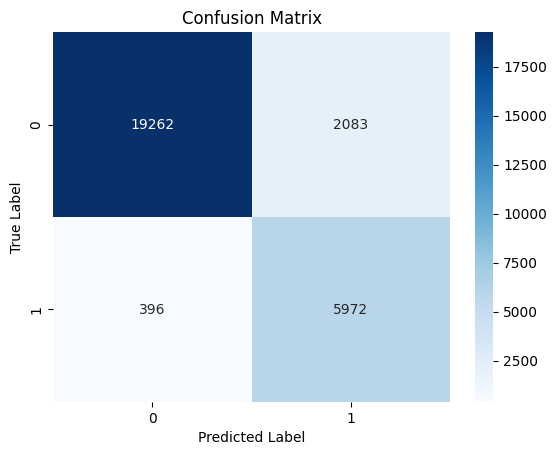

In [8]:
#Try 3 Ensemble Model (LSTM + CNN)

# Function to add Gaussian noise
def add_gaussian_noise(X, mean=0, std=0.01):
    noise = np.random.normal(mean, std, X.shape)
    X_noisy = X + noise
    return X_noisy

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(combined_train.drop('label', axis=1), combined_train['label'])

# Split the dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    X_resampled, y_resampled,
    random_state=42,
    stratify=y_resampled,
    shuffle=True,
    train_size=0.75
)

# Add noise to training data
x_train_noisy = add_gaussian_noise(x_train)

# Initialize the scaler
scaler = StandardScaler()
scaler.fit(x_train_noisy)

# Apply scaling to the training, validation, and test set
X_train_scaled = scaler.transform(x_train_noisy).reshape(-1, x_train_noisy.shape[1], 1)
X_val_scaled = scaler.transform(x_val).reshape(-1, x_val.shape[1], 1)
X_test_scaled = scaler.transform(combined_test.drop('label', axis=1)).reshape(-1, combined_test.drop('label', axis=1).shape[1], 1)# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Ensemble Model
def build_ensemble_model(input_shape):
    model = Sequential()

    # LSTM Layers
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(64, return_sequences=False))

    # CNN Layers
    model.add(Reshape((-1, 1)))  # Reshape for CNN
    model.add(Conv1D(64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(32, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())

    # Dense Layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    opt = Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    return model

input_shape = (X_train_scaled.shape[1], 1)
model = build_ensemble_model(input_shape)

# Train the model with class weights
history = model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_scaled, y_val),
    class_weight=class_weight_dict,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=8, verbose=1),
        ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
    ]
)

# Evaluate the model
model.load_weights('best_model.h5')
scores = model.evaluate(X_test_scaled, combined_test['label'], verbose=0)
print(f"Test Accuracy: {scores[1] * 100:.2f}%")


# Classification report and confusion matrix
y_pred = model.predict(X_test_scaled)
y_pred = (y_pred > 0.5).astype(int)
print(classification_report(combined_test['label'], y_pred, target_names=['Normal', 'Anomalous']))

# Confusion Matrix
conf_matrix = confusion_matrix(combined_test['label'], y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

## Conclusion
Following our experiments with CNN and LSTM models, we conclude with the best performing model was ***ENSEMBLE MODEL with CNN and LSTM*** with an accuracy of ***91.05%*** and discuss potential improvements and future work.
